# Number Plate Detection

In [1]:
import cv2 as cv
import numpy as np
import os.path


In [2]:
# Initialize the parameters

image_name = "images/test_3.png"
final_plates = []
confThreshold = 0.5      #Confidence threshold
nmsThreshold = 0.4       #Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image

save_detector = True    #Save Intermedate outputs

# Load names of classes
classesFile = "detection/classes.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Configuration and weight files for the model
modelConfiguration = "detection/darknet-yolov3.cfg";
modelWeights = "detection/lapi.weights";


In [3]:
# Loading the model
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


In [4]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]


In [5]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, num):
    # Draw a bounding box.
    #    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    global save_detector
    global image_name
    global final_plates
    temp_11 = frame[top:bottom, left:right]
    final_plates.append(temp_11.copy())
        
    if save_detector:
        temp_name = image_name.split("/")[-1].split(".")[0] + "_test_"+str(num)+".jpg"
        cv.imwrite(temp_name , temp_11)
        print("Number plate saved as", temp_name)
    
    cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)


    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)


In [6]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height, i)


In [7]:
# Open the image file
if not os.path.isfile(image_name):
    raise("Input image file ", image_name, " doesn't exist")

cap = cv.VideoCapture(image_name)
outputFile = image_name.split("/")[-1].split(".")[0] +'_yolo_out_py.jpg'

In [8]:
while cv.waitKey(1) < 0:

    # get frame from the video
    hasFrame, frame = cap.read()

    # Stop the program if reached end of video
    if not hasFrame:
        if save_detector:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
        break

    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    postprocess(frame, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    #cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Write the frame with the detection boxes
    if save_detector:
        cv.imwrite(outputFile, frame.astype(np.uint8));


out.shape :  (507, 6)
0.97335917  -  0.9696169  - th :  0.5
[0.17181729 0.67725825 0.273324   0.17995849 0.97335917 0.9696169 ]
out.shape :  (2028, 6)
0.876378  -  0.8753169  - th :  0.5
[0.51376003 0.5971831  0.12284669 0.0788969  0.876378   0.8753169 ]
out.shape :  (8112, 6)
Number plate saved as test_3_test_0.jpg
Number plate saved as test_3_test_1.jpg
Done processing !!!
Output file is stored as  test_3_yolo_out_py.jpg


In [9]:
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(final_plates)
for i in range(1, columns*rows +1):
    img = final_plates[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

<Figure size 800x800 with 2 Axes>

# Number Plate Recognition

In [10]:
import cv2
import numpy as np
import scipy.ndimage
import joblib
import pytesseract
from scipy.signal import find_peaks


In [11]:
def new_ocr(img, ans):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    (thresh, im_bw) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    in_im_bw = cv2.bitwise_not(im_bw)
    
    if sum(im_bw.flatten()) < sum(in_im_bw.flatten()):
        img = im_bw
    else:
        img = in_im_bw
    #height
    a,b = img.shape
    x = np.sum(img, axis=1)

    x = x*-1
    mins, _ = find_peaks(x)
    x = x*-1
    y = [m for m in range(a)] 

    scale = max(x)/max(y)
    x = x-((a//10)*scale)
    x[x<0] = 0

    top = 0
    bottom = a-1

    while(x[top]==0):
        top += 1

    while(x[bottom]==0):
        bottom -=1


    top = max(0, top-1)
    bottom = min(bottom+1, a-1)

    val_top = x[top]
    val_bottom = x[bottom]

    mins = [top] + list(mins) + [bottom]

    for i in mins:
        if i < a//2:
            if x[i]<=val_top:
                val_top = x[i]
                top = i
            else:
                continue

    for i in mins[::-1]:
        if i>a//2:
            if x[i]<=val_bottom:
                val_bottom = x[i]
                bottom = i
            else:
                continue
    #width
    img = img[top:bottom,:]
    a,b = img.shape


    x = np.sum(img, axis=0)
    x =x*-1
    mins, _ = find_peaks(x)
    x =x*-1
    y = [m for m in range(b)] 

    left = 0
    right = b-1

    while(x[left]==0):
        left+=1

    while(x[right]==0):
        right-=1

    for i in range(left, b//3):
        if x[i]==a*255:
            left = i+1


    for i in range(2*b//3, right):
        if x[i]==a*255:
            right = i-1

    left = max(0, left-1)
    right = min(right+1, b-1)

    val_left = x[left]
    val_right = x[right]

    mins = [left] + list(mins) + [right]

    for i in mins:
        if i < b//2:
            if x[i]<val_left:
                val_left = x[i]
                left = i
            else:
                continue
        else:
            if x[i]<=val_right:
                val_right = x[i]
                right = i
            else:
                continue
    img = img[:, left:right]
    a,b = img.shape
    print(a,b, b/a)
    brdr = int(a/2) 
    constant= cv2.copyMakeBorder(img,brdr,brdr,brdr,brdr,cv2.BORDER_CONSTANT)
    plt.imshow(constant, cmap = 'gray')
    pre_ans = pytesseract.image_to_string(constant)
    final_ans = ""
    allowed = [chr(i) for i in range(65,91)] + [chr(i) for i in range(48,58)] + [" "]
    for i in pre_ans:
        if i not in allowed:
            pass
        else:
            final_ans+=i
    return final_ans
    

(269, 1092, 3)
Tesseract Output 1H12DE1433
190 1025 5.394736842105263
Processed Output H12DE1433
-------------------------------------------------------------
(118, 490, 3)
Tesseract Output IN 37BU 3146
74 422 5.702702702702703
Processed Output N37BU 3146
-------------------------------------------------------------


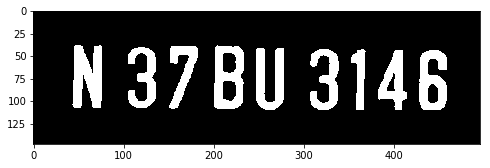

In [12]:
# model = "recognition/mlp.pkl"
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(final_plates)
for plate in final_plates:

    # Load image
    print(plate.shape)
    ans = pytesseract.image_to_string(plate)    
    print("Tesseract Output", ans)
    print("Processed Output", new_ocr(plate, ans))
    print("-------------------------------------------------------------")
